In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet201

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size
import keras.backend as K

Using TensorFlow backend.


# DenseNet201 Fine Tuning

In [2]:
X_train, y_train, X_valid, y_valid = load_data(Gray2RGB=True, mean_proc='DenseNet', img_size=224, test_size=0.1)

In [3]:
model_name = 'DenseNet201-Fine-Tune'

img_rows, img_cols, img_channel = 224, 224, 3
base_model = DenseNet201(weights='imagenet', include_top=False,
                         input_shape=(img_rows, img_cols, img_channel))

for layer in base_model.layers:
    layer.trainable = False
    #if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
    #    layer.trainable = True
    #    K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
    #    K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    #else:
    #    layer.trainable = False
# or if we want to set the first 20 layers of the network to be non-trainable
#for layer in model.layers[:20]:
#    layer.trainable=False
#for layer in model.layers[20:]:
#    layer.trainable=True

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dense(64,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
#x = Dropout(0.5)(x)
#x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv1_bn')(x)
x = Dense(64,activation='relu')(x) #dense layer 2
x = Dense(64,activation='relu')(x) 
#x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv1_bn')(x)
#x = Dropout(0.5)(x)

predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [4]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
#    vertical_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-4,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

model_path = './saved_models/DensetNet_0524001.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_acc', save_best_only=True, verbose=1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1, min_lr=0.000001, cooldown=1)

earlystop = EarlyStopping(monitor='val_acc', patience=8, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 16
aug_ratio = 2
steps_per_epoch = int(aug_ratio * X_train.shape[0] / batch_size)
validation_steps = int(aug_ratio * X_valid.shape[0] / batch_size)
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, learning_rate_reduction,earlystop],
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps)

Epoch 1/400
59/60 [============================>.] - ETA: 0s - loss: 1.5995 - acc: 0.3676
Epoch 00001: val_acc improved from -inf to 0.20370, saving model to ./saved_models/DensetNet_0524001.h5
60/60 [==============================] - 117s 2s/step - loss: 1.5973 - acc: 0.3656 - val_loss: 1.8242 - val_acc: 0.2037
Epoch 2/400
59/60 [============================>.] - ETA: 0s - loss: 1.0990 - acc: 0.5625
Epoch 00002: val_acc improved from 0.20370 to 0.40741, saving model to ./saved_models/DensetNet_0524001.h5
60/60 [==============================] - 14s 234ms/step - loss: 1.1044 - acc: 0.5604 - val_loss: 1.5888 - val_acc: 0.4074
Epoch 3/400
59/60 [============================>.] - ETA: 0s - loss: 0.8516 - acc: 0.6896
Epoch 00003: val_acc improved from 0.40741 to 0.44444, saving model to ./saved_models/DensetNet_0524001.h5
60/60 [==============================] - 14s 230ms/step - loss: 0.8486 - acc: 0.6897 - val_loss: 1.7335 - val_acc: 0.4444
Epoch 4/400
59/60 [============================>

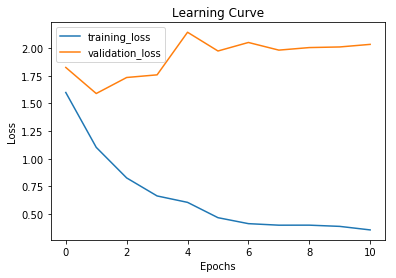

In [5]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

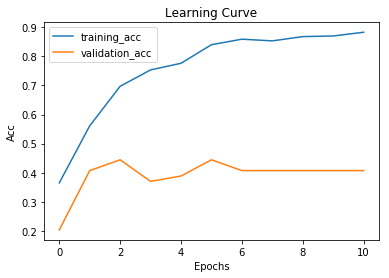

In [6]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [7]:
X_test, X_id = load_test_data(Gray2RGB=True, img_size=224, mean_proc='DenseNet')

model_path = './saved_models/DensetNet_0524001.h5'.format(model_name)
model = load_model(model_path)

#scores = model.evaluate(X_valid, y_valid, verbose=1)
#print('Validation loss:', scores[0])
#print('Validation accuracy:', scores[1])

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('DensetNet_0524001.csv'.format(model_name), index=False)